### Flight Prediction Algorithm

#### About 20% of flights are delayed every year, which has resulted in negative experiences as well as lost time and money. To improve customers' experiences, flight delays can be predicted using available data in order to  minimise future delays.

### Objectives:
* Analyse the factors and causes that lead to delays of flights.
* Predict whether a flight will be delayed based on given features with evaluation methods.


#### First let's import data libraries that will be needed

In [1]:
import pandas as pd
from zipfile import ZipFile
from numpy import*
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime, timedelta

#machine learning models
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from pickle import dump
from pickle import load


#### Import the last 2 years of data for faster computation

In [2]:
zipdir = 'AirOnTimeCSV.zip'
zipfile = ZipFile(zipdir)
csvlist = []

years_to_use = [str(i) for i in range(2011,2013)]

print('Reading CSV files...')
t_start = time.time()
#for csvfile in zipfile.infolist():
#fl_df = pd.read_csv(zipfile.open(csvfile.filename))
for i in range(len(zipfile.infolist())):
    for year in years_to_use:
        fname = zipfile.infolist()[i].filename
        if year in fname:
            fl_df = pd.read_csv(zipfile.open(fname))
            csvlist.append(fl_df)

fl_df = pd.concat(csvlist)
fl_df.reset_index(drop=True,inplace=True)

print('Done.\n')
t_end = time.time()
print('time to run: ', round((t_end - t_start)/60), ' minutes')

Reading CSV files...
Done.

time to run:  2  minutes


### DATA CLEANING

#### To prepare the data for the model, we have to remove unnecessary data, remove/impute data with little to no information, as well as do some feature engineeering.

#### First take a look at column header

In [3]:
pd.set_option('display.max_columns', len(fl_df.columns))
fl_df.head(10)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST,DEST_STATE_ABR,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 44
0,2011,1,1,6,2011-01-01,AA,N329AA,1,12478,JFK,NY,12892,LAX,CA,910.0,906.0,-4.0,0.0,0.0,-1.0,16.0,922.0,1156.0,13.0,1235.0,1209.0,-26.0,0.0,0.0,-2.0,0.0,NaN,0.0,385.0,363.0,334.0,1.0,2475.0,10,NaN,NaN,NaN,NaN,NaN,NaN
1,2011,1,2,7,2011-01-02,AA,N339AA,1,12478,JFK,NY,12892,LAX,CA,910.0,908.0,-2.0,0.0,0.0,-1.0,17.0,925.0,1227.0,9.0,1235.0,1236.0,1.0,1.0,0.0,0.0,0.0,NaN,0.0,385.0,388.0,362.0,1.0,2475.0,10,NaN,NaN,NaN,NaN,NaN,NaN
2,2011,1,3,1,2011-01-03,AA,N332AA,1,12478,JFK,NY,12892,LAX,CA,910.0,907.0,-3.0,0.0,0.0,-1.0,20.0,927.0,1226.0,13.0,1235.0,1239.0,4.0,4.0,0.0,0.0,0.0,NaN,0.0,385.0,392.0,359.0,1.0,2475.0,10,NaN,NaN,NaN,NaN,NaN,NaN
3,2011,1,4,2,2011-01-04,AA,N335AA,1,12478,JFK,NY,12892,LAX,CA,910.0,900.0,-10.0,0.0,0.0,-1.0,21.0,921.0,1202.0,15.0,1235.0,1217.0,-18.0,0.0,0.0,-2.0,0.0,NaN,0.0,385.0,377.0,341.0,1.0,2475.0,10,NaN,NaN,NaN,NaN,NaN,NaN
4,2011,1,5,3,2011-01-05,AA,N335AA,1,12478,JFK,NY,12892,LAX,CA,910.0,904.0,-6.0,0.0,0.0,-1.0,14.0,918.0,1158.0,16.0,1235.0,1214.0,-21.0,0.0,0.0,-2.0,0.0,NaN,0.0,385.0,370.0,340.0,1.0,2475.0,10,NaN,NaN,NaN,NaN,NaN,NaN
5,2011,1,6,4,2011-01-06,AA,N338AA,1,12478,JFK,NY,12892,LAX,CA,910.0,1045.0,95.0,95.0,1.0,6.0,18.0,1103.0,1339.0,12.0,1235.0,1351.0,76.0,76.0,1.0,5.0,0.0,NaN,0.0,385.0,366.0,336.0,1.0,2475.0,10,76.0,0.0,0.0,0.0,0.0,NaN
6,2011,1,7,5,2011-01-07,AA,N329AA,1,12478,JFK,NY,12892,LAX,CA,910.0,906.0,-4.0,0.0,0.0,-1.0,59.0,1005.0,1247.0,9.0,1235.0,1256.0,21.0,21.0,1.0,1.0,0.0,NaN,0.0,385.0,410.0,342.0,1.0,2475.0,10,0.0,0.0,21.0,0.0,0.0,NaN
7,2011,1,8,6,2011-01-08,AA,N338AA,1,12478,JFK,NY,12892,LAX,CA,910.0,905.0,-5.0,0.0,0.0,-1.0,28.0,933.0,1155.0,19.0,1235.0,1214.0,-21.0,0.0,0.0,-2.0,0.0,NaN,0.0,385.0,369.0,322.0,1.0,2475.0,10,NaN,NaN,NaN,NaN,NaN,NaN
8,2011,1,9,7,2011-01-09,AA,N329AA,1,12478,JFK,NY,12892,LAX,CA,910.0,906.0,-4.0,0.0,0.0,-1.0,18.0,924.0,1206.0,14.0,1235.0,1220.0,-15.0,0.0,0.0,-1.0,0.0,NaN,0.0,385.0,374.0,342.0,1.0,2475.0,10,NaN,NaN,NaN,NaN,NaN,NaN
9,2011,1,10,1,2011-01-10,AA,N329AA,1,12478,JFK,NY,12892,LAX,CA,910.0,909.0,-1.0,0.0,0.0,-1.0,24.0,933.0,1216.0,11.0,1235.0,1227.0,-8.0,0.0,0.0,-1.0,0.0,NaN,0.0,385.0,378.0,343.0,1.0,2475.0,10,NaN,NaN,NaN,NaN,NaN,NaN


#### Check column data types as well as number of non-null entries

In [4]:
fl_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12182043 entries, 0 to 12182042
Data columns (total 45 columns):
 #   Column               Non-Null Count     Dtype  
---  ------               --------------     -----  
 0   YEAR                 12182043 non-null  int64  
 1   MONTH                12182043 non-null  int64  
 2   DAY_OF_MONTH         12182043 non-null  int64  
 3   DAY_OF_WEEK          12182043 non-null  int64  
 4   FL_DATE              12182043 non-null  object 
 5   UNIQUE_CARRIER       12182043 non-null  object 
 6   TAIL_NUM             12146306 non-null  object 
 7   FL_NUM               12182043 non-null  int64  
 8   ORIGIN_AIRPORT_ID    12182043 non-null  int64  
 9   ORIGIN               12182043 non-null  object 
 10  ORIGIN_STATE_ABR     12182043 non-null  object 
 11  DEST_AIRPORT_ID      12182043 non-null  int64  
 12  DEST                 12182043 non-null  object 
 13  DEST_STATE_ABR       12182043 non-null  object 
 14  CRS_DEP_TIME         12182042 no

###### The data contains 12,182,043 entries and 45 columns (including departure/arrival columns). Columns have mostly  non-null entries (>~12,000,000) except for CANCELLATION_CODE and columns containing information about causes for delays (e.g. weather, security). 

#### First, save a portion of data in a seperate dataframe for test/validation purposes and convert FL_DATE column to date (for data exploration section). Also use about 20% of the data (random sample selection) for faster computation. This sample has similar distributions compared to the dataset, so we can use this instead.

In [5]:
fl_df['FL_DATE'] = pd.to_datetime(fl_df['FL_DATE'], format='%Y-%m-%d')
#fl_df['FL_DATE_DAYS'] = (pd.to_datetime(fl_df['FL_DATE']) - datetime(1970,1,1)).dt.days

####
fl_df = fl_df.sample(n=int(2e6)).reset_index(drop=True)
val_df = fl_df.sample(frac=0.001).reset_index(drop=True)
fl_df  = fl_df.drop(val_df.index).reset_index(drop=True)
print('Model Dataset:',fl_df.shape)
print('Validation Dataset:',val_df.shape)
####

##Save to CSV
val_df.to_csv('hold_out_test.csv',index=False)

fl_df.reset_index(drop=True,inplace=True)

Model Dataset: (1998000, 45)
Validation Dataset: (2000, 45)


#### Drop rows where flights were cancelled/diverted as these won't have appropriate delay information. Since we'll look at both departure and arrival delay data, drop empty rows in CRS_DEP_TIME, DEP_TIME, CRS_ARR_TIME and ARR_TIME columns (i.e. no departure/arrival times available). There are only a few of these values after cancelled/diverted flights are removed. Also drop any column with only missing values.

In [6]:
##cancellation/diverted flights
#fl_df = fl_df[fl_df['CANCELLATION_CODE'].notnull()]
fl_df = fl_df[fl_df['CANCELLED'] == 0]
fl_df = fl_df[fl_df['DIVERTED'] == 0]
fl_df.drop(['CANCELLED','CANCELLATION_CODE','DIVERTED'], axis=1, inplace=True)

##rows with no departure/arrival times
fl_df.dropna(subset=['CRS_DEP_TIME','DEP_TIME','CRS_ARR_TIME','ARR_TIME'], inplace=True)

##empty columns
fl_df.dropna(axis=1, how='all', inplace=True)

#### Convert 'CRS_DEP_TIME', 'DEP_TIME', 'CRS_ARR_TIME' and  'ARR_TIME' from floats to time (in hours) using created function conv_to_time(df,col) to use in data exploration section later. 

In [7]:
def conv_to_time(df,col):
    df[col] = df[col].astype('int64')
    df[col] = df[col].astype('str')
    df[col] = df[col].apply('{0:0>4}'.format)
    df[col].replace('2400', '0000', inplace=True)
    df[col] = pd.to_datetime(df[col], format='%H%M').dt.hour
    return df[col]
    

cols_to_conv = ['CRS_DEP_TIME','DEP_TIME','CRS_ARR_TIME','ARR_TIME']
for col in cols_to_conv:
    print(col)
    fl_df[col] = conv_to_time(fl_df,col)

CRS_DEP_TIME
DEP_TIME
CRS_ARR_TIME
ARR_TIME


#### Now rows contain non-null values except for cause of delay feature columns, and dates and times have been converted.

In [8]:
print(fl_df.info(null_counts=True))
fl_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1961712 entries, 0 to 1997999
Data columns (total 41 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   YEAR                 1961712 non-null  int64         
 1   MONTH                1961712 non-null  int64         
 2   DAY_OF_MONTH         1961712 non-null  int64         
 3   DAY_OF_WEEK          1961712 non-null  int64         
 4   FL_DATE              1961712 non-null  datetime64[ns]
 5   UNIQUE_CARRIER       1961712 non-null  object        
 6   TAIL_NUM             1961712 non-null  object        
 7   FL_NUM               1961712 non-null  int64         
 8   ORIGIN_AIRPORT_ID    1961712 non-null  int64         
 9   ORIGIN               1961712 non-null  object        
 10  ORIGIN_STATE_ABR     1961712 non-null  object        
 11  DEST_AIRPORT_ID      1961712 non-null  int64         
 12  DEST                 1961712 non-null  object        
 1

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST,DEST_STATE_ABR,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2011,1,5,3,2011-01-05,DL,N656DL,2267,15304,TPA,FL,10397,ATL,GA,8,8,-3.0,0.0,0.0,-1.0,17.0,844.0,1001.0,9.0,10,10,0.0,0.0,0.0,0.0,100.0,103.0,77.0,1.0,406.0,2,NaN,NaN,NaN,NaN,NaN
1,2012,6,18,1,2012-06-18,EV,N925EV,5349,11146,CRW,WV,10397,ATL,GA,7,7,-5.0,0.0,0.0,-1.0,18.0,728.0,826.0,10.0,8,8,-15.0,0.0,0.0,-1.0,96.0,86.0,58.0,1.0,363.0,2,NaN,NaN,NaN,NaN,NaN
2,2011,7,19,2,2011-07-19,WN,N484WN,889,13198,MCI,MO,10821,BWI,MD,6,5,-2.0,0.0,0.0,-1.0,6.0,604.0,909.0,2.0,9,9,-14.0,0.0,0.0,-1.0,145.0,133.0,125.0,1.0,967.0,4,NaN,NaN,NaN,NaN,NaN
3,2012,7,29,7,2012-07-29,US,N540UW,839,14100,PHL,PA,13204,MCO,FL,20,20,14.0,14.0,0.0,0.0,35.0,2134.0,2327.0,4.0,23,23,15.0,15.0,1.0,1.0,151.0,152.0,113.0,1.0,861.0,4,12.0,0.0,1.0,0.0,2.0
4,2012,5,12,6,2012-05-12,WN,N510SW,2352,12451,JAX,FL,10693,BNA,TN,11,11,6.0,6.0,0.0,0.0,9.0,1125.0,1138.0,8.0,11,11,6.0,6.0,0.0,0.0,90.0,90.0,73.0,1.0,483.0,2,NaN,NaN,NaN,NaN,NaN


#### Drop ORIGIN_AIRPORT_ID and DEST_AIRPORT_ID because they are correlated with ORIGIN and DEST.

In [9]:
print('\nNumber of unique ORIGIN_AIRPORT_ID:')
print(fl_df['ORIGIN_AIRPORT_ID'].nunique())
print('\nNumber of unique ORIGIN:')
print(fl_df['ORIGIN'].nunique())
fl_df.drop('ORIGIN_AIRPORT_ID', axis=1, inplace=True)

print('\nNumber of unique DEST_AIRPORT_ID:')
print(fl_df['DEST_AIRPORT_ID'].nunique())
print('\nNumber of unique DEST:')
print(fl_df['DEST'].nunique())

fl_df.drop('DEST_AIRPORT_ID', axis=1, inplace=True)



Number of unique ORIGIN_AIRPORT_ID:
316

Number of unique ORIGIN:
316

Number of unique DEST_AIRPORT_ID:
318

Number of unique DEST:
318


#### Cause of delay columns (in minutes), viz. CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY and LATE_AIRCRAFT_DELAY,  have mostly empty rows (~20% filled). We still want to keep these features because they may be important in determing whether flights will be delayed. These columns have non-null values in the same rows, suggesting a correlation between these features.

In [10]:
cols_to_check = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY','LATE_AIRCRAFT_DELAY']
print('Number of rows where cause of delay columns are non-null:')
print(len(fl_df[cols_to_check].dropna(how='any')))

Number of rows where cause of delay columns are non-null:
348320


#### Plot histogram of numerical columns to see distribution of numerical columns and print value counts of all categorical columns to see distribution of categorical columns.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128433dd0>,
      dtype=object)

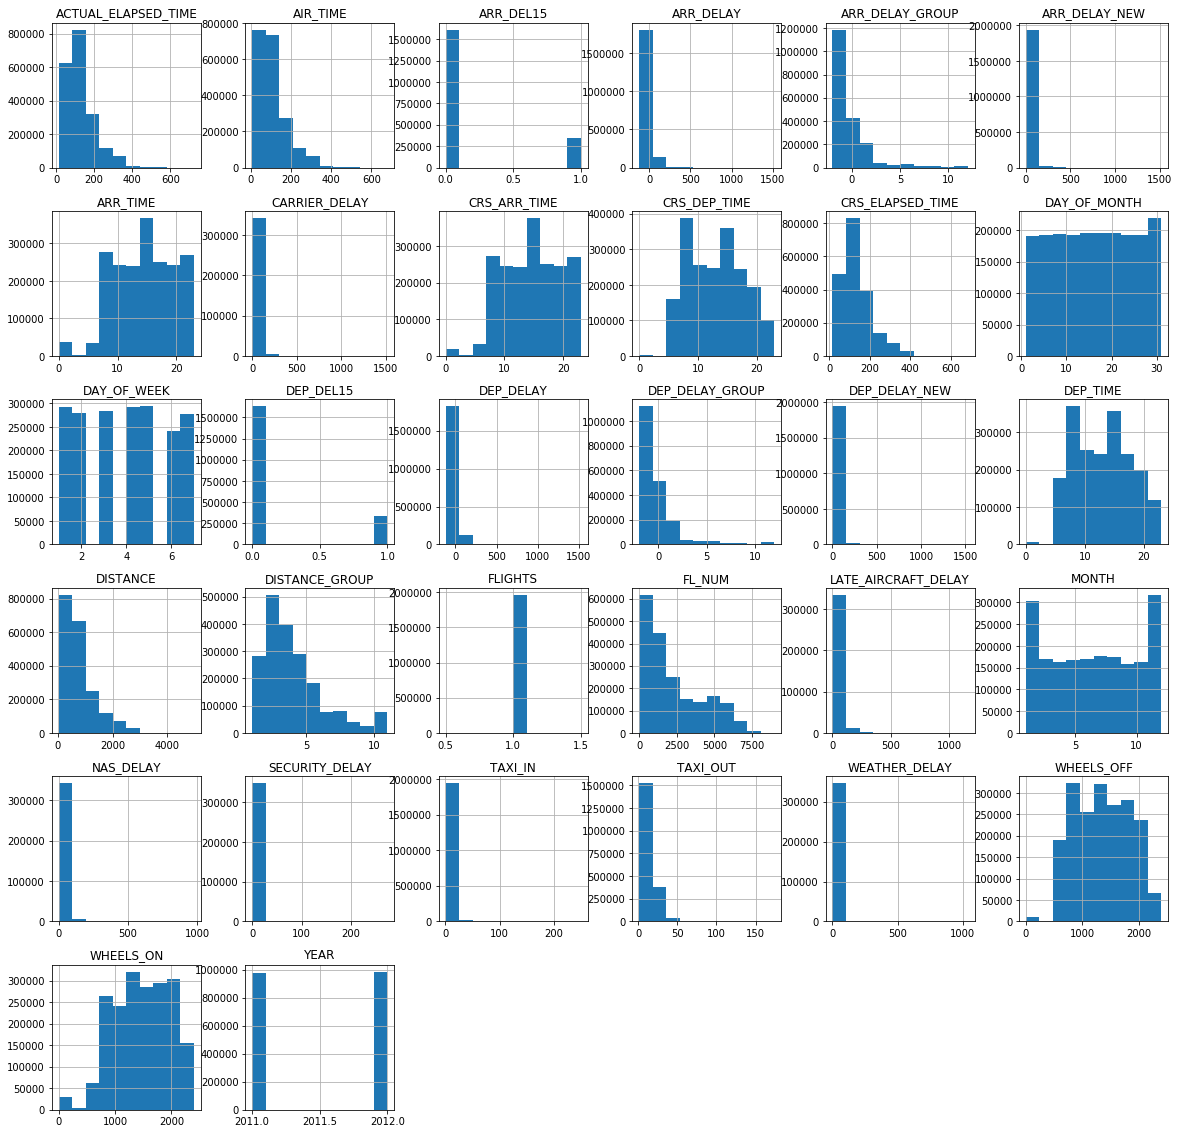

In [11]:
## find list of numerical and categorical columns
num_cols = list(fl_df.select_dtypes(['number']).columns)
cat_cols = list(fl_df.select_dtypes(['object']).columns)

## plot histogram of numerical columns
fl_df.hist(figsize=(20,20))

In [12]:
## print value counts of all categorical columns
for col in cat_cols:
    print(fl_df[col].value_counts(dropna=False),'\n')

WN    371614
DL    236627
OO    193345
EV    170676
AA    169941
MQ    146082
UA    136021
US    131752
FL     75867
B6     72376
XE     65201
AS     47372
YV     46471
CO     39424
F9     26892
HA     23205
VX      8846
Name: UNIQUE_CARRIER, dtype: int64 

N477HA    1311
N486HA    1294
N484HA    1269
N485HA    1248
N475HA    1227
          ... 
N831MH       1
N199UA       1
N104UA       1
N180UA       1
N760NW       1
Name: TAIL_NUM, Length: 4823, dtype: int64 

ATL    126186
ORD     99463
DFW     85490
DEN     77009
LAX     70629
        ...  
SHD         8
TTN         3
PLN         3
LYH         1
BPT         1
Name: ORIGIN, Length: 316, dtype: int64 

CA    241088
TX    224379
FL    146625
IL    132425
GA    132079
CO     87089
NY     83312
AZ     69367
NC     64405
VA     59952
NV     53633
PA     39971
UT     38128
WA     37508
MO     37421
TN     36683
NJ     36548
MI     36145
MN     35722
HI     34924
MA     34072
MD     33293
OH     31061
OR     21704
LA     20612
WI     1927

#### Some of the categories for certain categorical features (e.g. FL_NUM and TAIL_NUM) have very few counts. Many of the numerical features are skewed, they may need to be log transformed to improve predictions. We also see data imbalance in the delay indicators, DEP_DEL15 and ARR_DEL15, these will need to be resampled to balance the data and improve predictions. For now, remove FLIGHTS as it only contains one unique value.

In [13]:
fl_df.drop('FLIGHTS', axis=1, inplace=True)

### EXPLORING THE DATA

#### Plotting the distribution of depature and arrival delay indicators, we see that, as stated above, most of the data (~80%) have delays <15min.  Departure delays range from ~-4hrs to ~31hrs (the 2-year full dataset) and arrival delays range from ~-7hrs to ~30hrs (the 2-year full dataset) . About 60% are early and less than 2% are delayed more than 2hrs.

min DEP delay: -120.0  max DEP delay: 1526.0
min ARR delay: -122.0  max ARR delay: 1517.0 

Fraction of early departures (<0mins): 0.5701672824553248
Fraction  of late depatures > 2hrs: 0.0167037771089742 

Fraction  of early arrivals (<0mins): 0.6059732519350445
Fraction  of late arrivals > 2hrs: 0.016982105426280716 



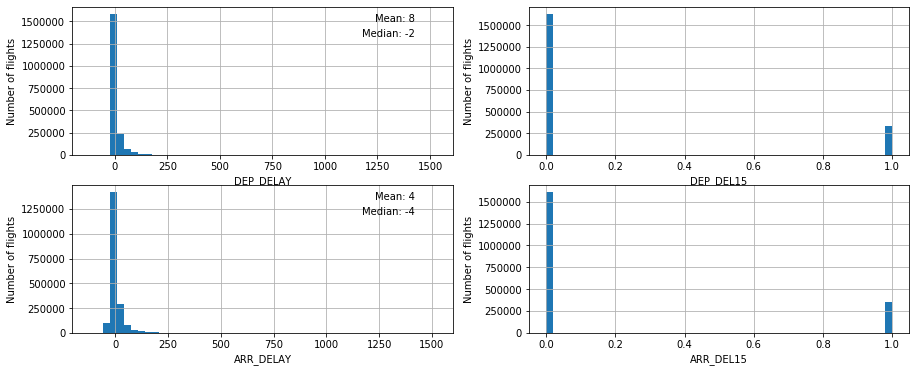

In [14]:
print('min DEP delay:',min(fl_df['DEP_DELAY']),' max DEP delay:',max(fl_df['DEP_DELAY']))
print('min ARR delay:',min(fl_df['ARR_DELAY']),' max ARR delay:',max(fl_df['ARR_DELAY']), '\n')
cols_to_plot = ['DEP_DELAY','DEP_DEL15','ARR_DELAY','ARR_DEL15']
## Plot distribution of delays
fig, ax1 = plt.subplots(2,2,figsize=(15,6))
for b, a in zip(cols_to_plot, ax1.flatten()):
    fl_df[b].hist(bins=50,ax=a)
    if b in ['DEP_DELAY','ARR_DELAY']:
        a.annotate('Mean: {:.0f}'.format(fl_df[b].mean()), xy=(0.9,0.9),xycoords='axes fraction',ha='right')
        a.annotate('Median: {:.0f}'.format(fl_df[b].median()), xy=(0.9,0.8),xycoords='axes fraction',ha='right')
    a.set_xlabel(b)
    a.set_ylabel('Number of flights')

len_del = len(fl_df['DEP_DELAY'])
print('Fraction of early departures (<0mins):', len(fl_df[fl_df['DEP_DELAY']<0])/len_del)
print('Fraction  of late depatures > 2hrs:', len(fl_df[fl_df['DEP_DELAY']>60*2])/len_del, '\n')
print('Fraction  of early arrivals (<0mins):', len(fl_df[fl_df['ARR_DELAY']<0])/len_del)
print('Fraction  of late arrivals > 2hrs:', len(fl_df[fl_df['ARR_DELAY']>60*2])/len_del, '\n')

#### Looking at the average weekly delay of flights, we see that between around 2011-03 and 2011-08, departure and arrival delay times are on average about 10 and 5 minutes, respectively. They decrease to about 5 and 0 minutes on average, respectively, during 2011-10 and 2012-04. The increase/decrease in delay times is correlated with the increase/decrease in the number of flights. There are more people traveling during the spring/summer months, and therefore, there are more flights during this period, which in turn means delay times increase. Arrival delays are generally lower than departure delays, indicating that airlines make adjustments (e.g. flight speed, etc.) in order to reduce arrival delays.

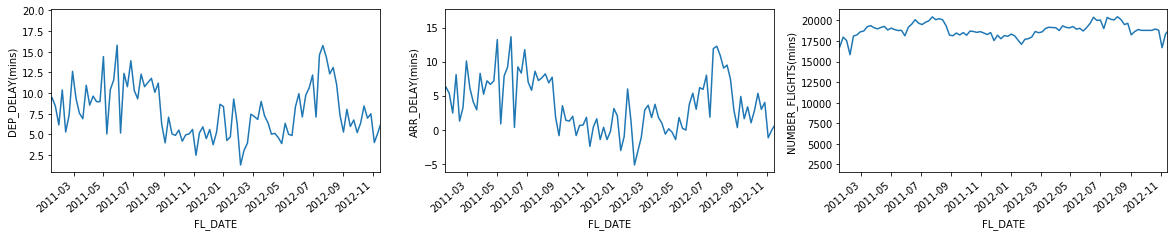

In [15]:
## Plot Average delays vs FL_DATE
del_avg = fl_df[['FL_DATE','DEP_DELAY']].resample('W',on='FL_DATE').mean().reset_index()
del_avg['ARR_DELAY'] = fl_df[['FL_DATE','ARR_DELAY']].resample('W',on='FL_DATE').mean().reset_index()['ARR_DELAY']
del_avg_t = fl_df[['FL_DATE','ARR_DELAY']].resample('W',on='FL_DATE').count()
del_avg_t.drop('FL_DATE',axis=1,inplace=True)
del_avg['NUMBER_FLIGHTS'] = del_avg_t.reset_index()['ARR_DELAY']

cols_to_plot = ['DEP_DELAY','ARR_DELAY','NUMBER_FLIGHTS']
fig,ax1=plt.subplots(1,3,figsize=(20,3))
for b, a in zip(cols_to_plot, ax1.flatten()):
    a.plot(del_avg['FL_DATE'],del_avg[b],'-')
    a.set_xlabel('FL_DATE')
    a.set_ylabel(b+'(mins)')
    a.set_xlim(left=datetime(2011,1,15),right=datetime(2012,11,15))
    for label in a.get_xticklabels():
        label.set_rotation(40)
        label.set_ha('right')

#### Delayed departures and arrivals follow the same trends. The fraction of delayed departures and arrivals vs day of week, day of month and month shows that a higher fraction of flights are delayed on Mondays, Thursdays and Fridays. There is also a higher fraction of delayed flights during June, July, August and December, as would be expected. 

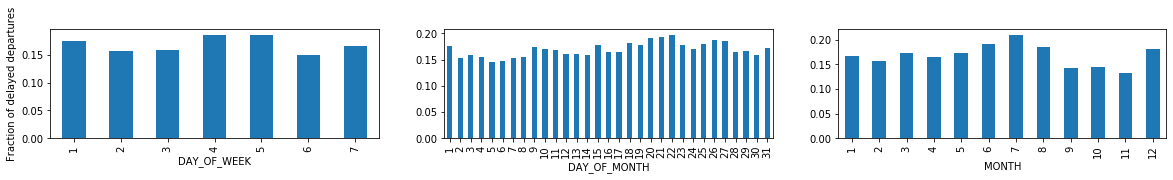

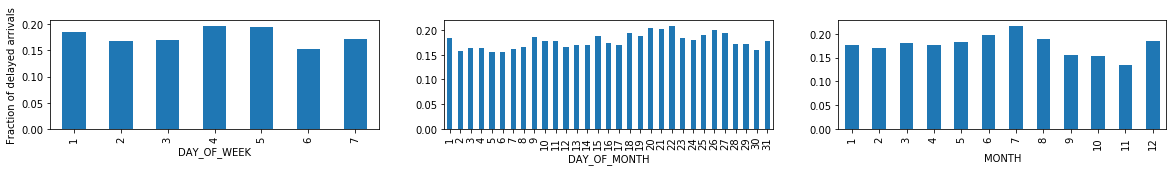

In [16]:
def plot_bars(df,nplots,colstoplot,avgcol,avgcollabel,fig_size):
    fig,ax1=plt.subplots(1,nplots,figsize=fig_size)
    for b, a in zip(colstoplot, ax1.flatten()):
        df.groupby(b)[avgcol].mean().plot(kind='bar',ax=a)
    ax1[0].set_ylabel(avgcollabel)
    
cols_to_plot = ['DAY_OF_WEEK','DAY_OF_MONTH','MONTH']
y_to_plot = ['DEP_DEL15','ARR_DEL15']
y_label = ['Fraction of delayed departures','Fraction of delayed arrivals']
for i in range(2):
    plot_bars(fl_df,3,cols_to_plot,y_to_plot[i],y_label[i],(20,2)) 

#### The fraction of delayed departures and arrivals vs 'CRS_DEP_TIME', 'DEP_TIME', 'ARR_TIME' and 'CRS_ARR_TIME' shows that scheduled departure times and actual departure times have similar distributions compared to scheduled arrival times and actual arrival times, respectively, with a 2hr delay. The number of delays are at a minimum in the mornings (~05:00-07:00) and are the highest at night and early mornings (before 03:00).

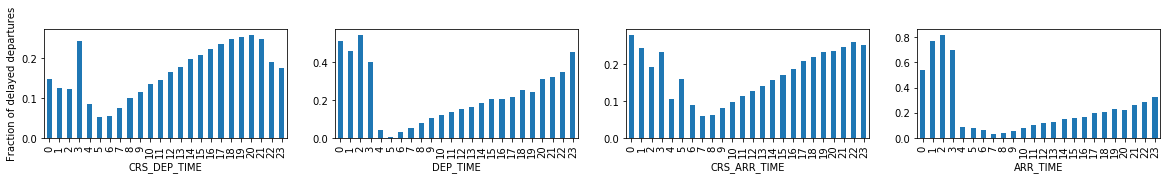

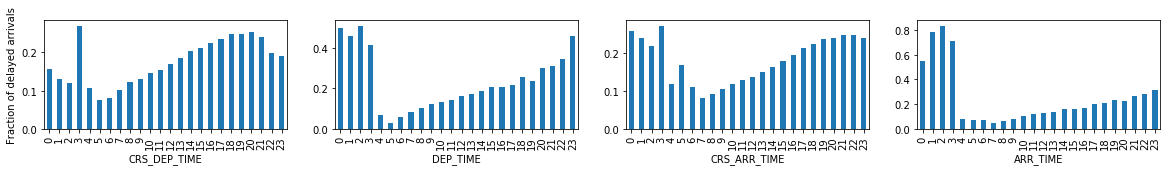

In [17]:
cols_to_plot = ['CRS_DEP_TIME','DEP_TIME','CRS_ARR_TIME', 'ARR_TIME']
y_to_plot = ['DEP_DEL15','ARR_DEL15']
y_label = ['Fraction of delayed departures','Fraction of delayed arrivals']
for i in range(2):
    plot_bars(fl_df,4,cols_to_plot,y_to_plot[i],y_label[i],(20,2))

#### For the categorical data, plotting the proprtion of DEP_DEL15 vs UNIQUE_CARRIER, ORIGIN_STATE_ABR and DEST_STATE_ABR shows that if an airline/origin/destination has a larger portion of delays, then it also has a larger portion of flights that are not delayed. This means that airlines/airports with the largest portion of delays are also the busiest airlines/airports. The 3 busiest origin states/destination states are  Carlifornia, Texas and Florida, and the 3 busiest airlines in 2011and 2012 are Southwest Airlines Co., Delta Air Lines Inc. and SkyWest Airlines Inc.

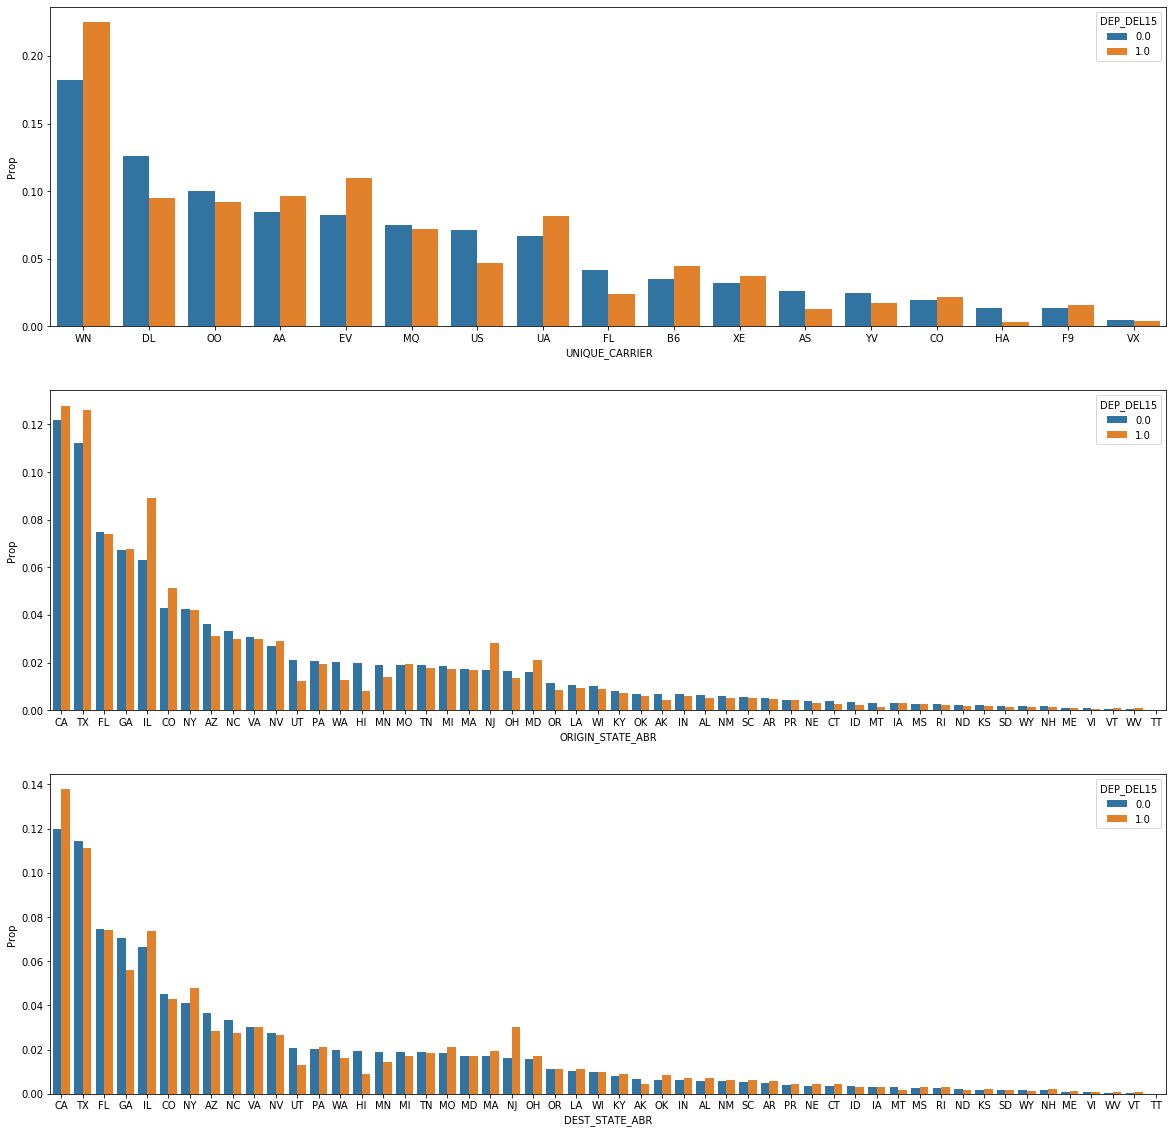

In [18]:
## Plot distribution

cols_to_plot = ['UNIQUE_CARRIER','ORIGIN_STATE_ABR','DEST_STATE_ABR']

fig,ax1 = plt.subplots(len(cols_to_plot),1,figsize=(20,20))
#for i in range(2):
for b, a in zip(cols_to_plot, ax1.flatten()):
    #sns.countplot(x=b, hue='DEP_DEL15', data=fl_df, ax=a)

    prop_df = (fl_df[b].groupby(fl_df['DEP_DEL15']).value_counts(normalize=True).rename('Prop').reset_index())
    sns.barplot(x=b, y='Prop', hue='DEP_DEL15', data=prop_df, ax=a)

## MODELLING THE DATA

#### Drop the created 'FL_DATE' feature, we will not be using it in the model.

In [19]:
## remove created date feature for next steps
fl_df.drop('FL_DATE',axis=1,inplace=True)

#### In the mext sections we will model whether departures/arrivals will be delayed based on DEP_DEL15 and ARR_DEL15, which have two classes, viz. no delay (<15min), delay (>15min). 

#### As stated earlier, there is data imbalance in the delay indicators, DEP_DEL15 and ARR_DEL15, so we resample the classes to balance the data and improve predictions such that there are 300,000 samples for each class (to save time on computation).

In [20]:
##Function to balance data
def balance_df(df,bal_col,size):
    imb = df[bal_col].value_counts()
    print('\n',bal_col+' Class imbalance:')
    print(imb)
    ##Sample the classes and shuffle
    class0 = df[df[bal_col]==0].sample(n=size)
    class1 = df[df[bal_col]==1].sample(n=size)
    df_new = class0.append(class1)
    df_new = df_new.sample(frac=1).reset_index(drop=True)
    print('\nBalanced dataset:')
    print(df_new[bal_col].value_counts())
    len(df_new.columns)
    return df_new

lsize=int(3e5)
#lsize=int(1e6)
#lsize=int(1.5e6)
## Depature Delays
fl_dep = balance_df(fl_df,'DEP_DEL15',lsize)

## Arrival Delays
fl_arr = balance_df(fl_df,'ARR_DEL15',lsize)


 DEP_DEL15 Class imbalance:
0.0    1629948
1.0     331764
Name: DEP_DEL15, dtype: int64

Balanced dataset:
1.0    300000
0.0    300000
Name: DEP_DEL15, dtype: int64

 ARR_DEL15 Class imbalance:
0.0    1613392
1.0     348320
Name: ARR_DEL15, dtype: int64

Balanced dataset:
1.0    300000
0.0    300000
Name: ARR_DEL15, dtype: int64


#### Check if there are highly correlated features:

#### Both departure and arrival samples have similar correlation heatmaps. 

* Departure delay features are correlated to arrival delay features, as expected, especially, DEP_DELAY and DEP_DELAY_NEW with ARR_DELAY and ARR_DELAY_NEW.
* CRS_DEP_TIME, DEP_TIME, CRS_ARR_TIME, ARR_TIME, WHEELS_OFF and WHEELS_ON are correlated to each other and not to TAXI_OUT and TAXI_IN. TAXI_OUT and TAXI_IN would generally depend more on the distances at the airport and airport operations, so they would be relatively constant per airport. 
* Cause of delay columns, viz. CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY and LATE_AIRCRAFT_DELAY are highly correlated to ARR_DEL15 but not as much to DEP_DEL15, but they are in general correlated to delay features.
* CRS_ELAPSED_TIME,	ACTUAL_ELAPSED_TIME and AIR_TIME are highly correlated. These would not have been used for the prediction algorithm anyway, so these drooped.
* DISTANCE and DISTANCE_GROUP are correlation to each other, so we drop DISTANCE_GROUP.

Text(0.5, 1, '\nCorrelation of features for departure data sample')

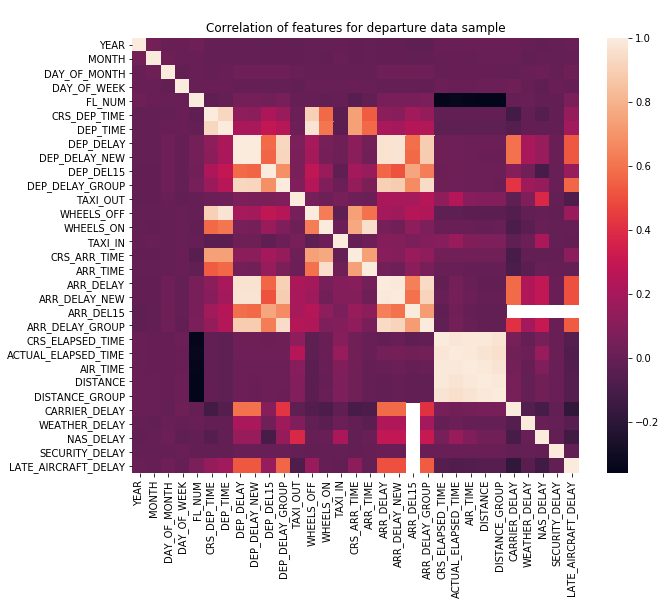

In [21]:
## Plot correlation heatmap: DEP sample
fig,ax=plt.subplots(figsize=(10,8))
corr = fl_dep.corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)
plt.title('\nCorrelation of features for departure data sample')

Text(0.5, 1, '\nCorrelation of features for arrival data sample')

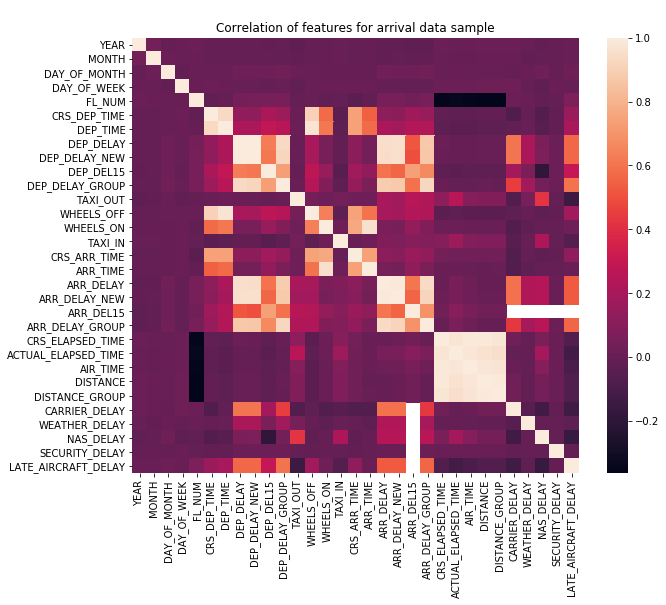

In [22]:
## Plot correlation heatmap: ARR sample
fig,ax=plt.subplots(figsize=(10,8))
corr = fl_arr.corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)
plt.title('\nCorrelation of features for arrival data sample')

#### Let's develop 3 models
1. Predict weather flight departures will be delayed.
2. Predict weather flight arrivals will be delayed, including some depature information
3. Predict weather flight arrivals will be delayed, excluding some depature information

#### Based on this, we drop the following features in the datasets:
1. DEP_TIME, DEP_DELAY, DEP_DELAY_NEW, DEP_DELAY_GROUP, TAXI_OUT, TAXI_IN, WHEELS_OFF, WHEELS_ON, ARR_TIME, ARR_DELAY, ARR_DELAY_NEW, ARR_DEL15, ARR_DELAY_GROUP, ACTUAL_ELAPSED_TIME, AIR_TIME and DISTANCE_GROUP
2. DEP_DELAY_NEW, DEP_DEL15, DEP_DELAY_GROUP, TAXI_IN, WHEELS_ON, AIR_TIME, ARR_DELAY, ARR_DELAY_NEW, ARR_DELAY_GROUP, ACTUAL_ELAPSED_TIME, and DISTANCE_GROUP
3. Same as 2. but also drop DEP_TIME, DEP_DELAY, TAXI_OUT and WHEELS_OFF and cause of delay columns.

In [23]:
##MODEL 1 data
cols_to_drop = ['DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DELAY_GROUP', 'TAXI_OUT', 'TAXI_IN', 'WHEELS_OFF',\
                'WHEELS_ON', 'ARR_TIME', 'ARR_DELAY', 'TAIL_NUM', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 
                'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE_GROUP', 'YEAR']
fl_dep1 = fl_dep.drop(cols_to_drop,axis=1)

##MODEL 2 data
cols_to_drop = ['DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'TAXI_IN', 'WHEELS_ON', 'ARR_TIME', 'ARR_DELAY', \
                'ARR_DELAY_NEW','ARR_DELAY_GROUP','TAIL_NUM','ACTUAL_ELAPSED_TIME','AIR_TIME','DISTANCE_GROUP','YEAR']
fl_arr1 = fl_arr.drop(cols_to_drop,axis=1)

##MODEL 3 data
cols_to_drop = ['DEP_TIME','DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'TAXI_OUT', 'TAXI_IN',\
                'WHEELS_OFF', 'WHEELS_ON', 'ARR_TIME', 'ARR_DELAY', 'TAIL_NUM', 'ARR_DELAY_NEW', 'ARR_DELAY_GROUP',\
                'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE_GROUP', 'YEAR','CARRIER_DELAY',\
                'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY','LATE_AIRCRAFT_DELAY']
fl_arr2 = fl_arr.drop(cols_to_drop,axis=1)

#### As stated earlier, histograms of numerical features show some skewed distributions, so these features are log transformed to improve predictions.

/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


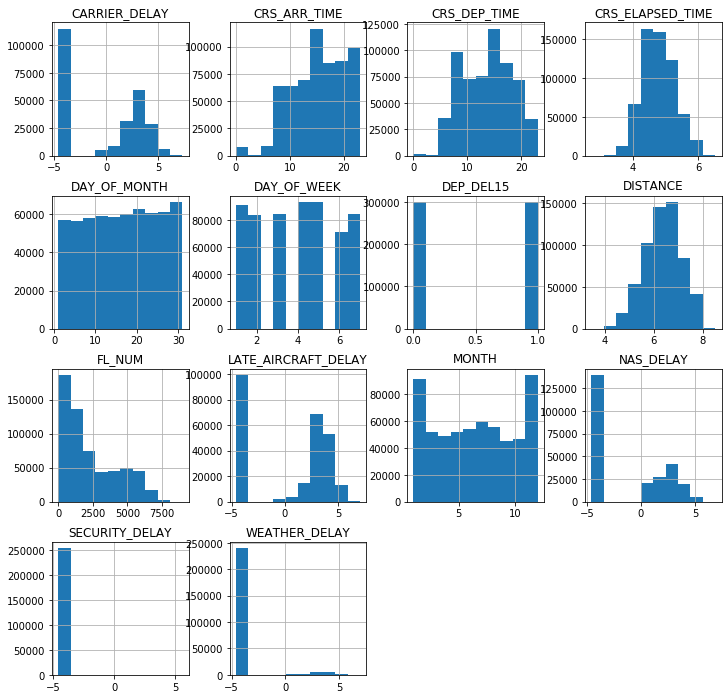

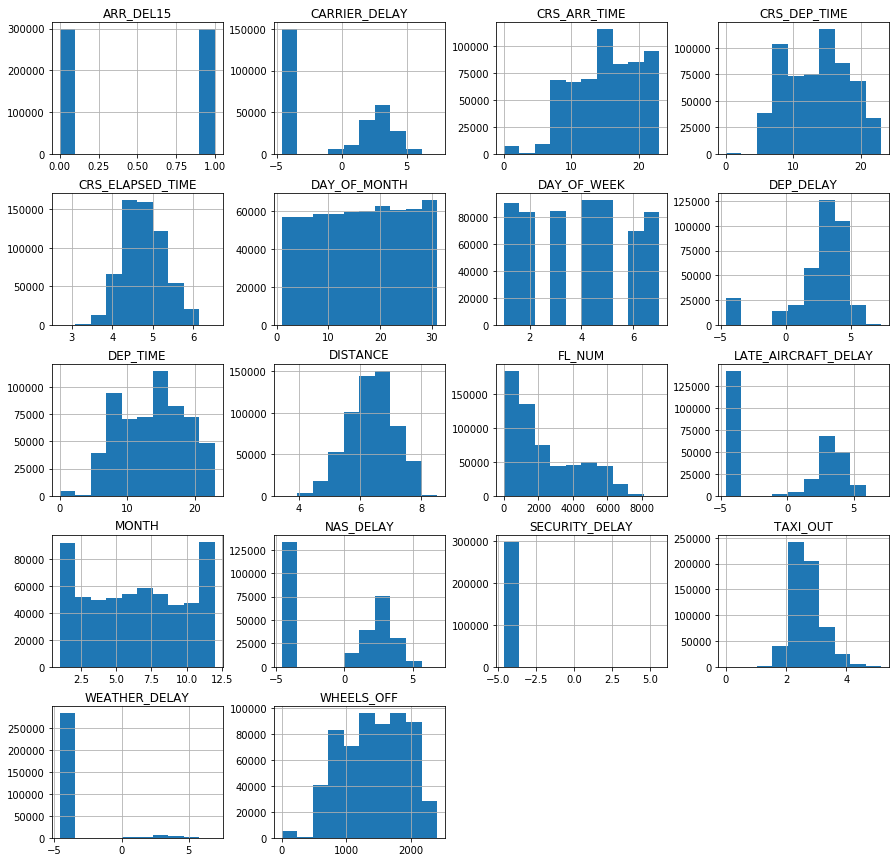

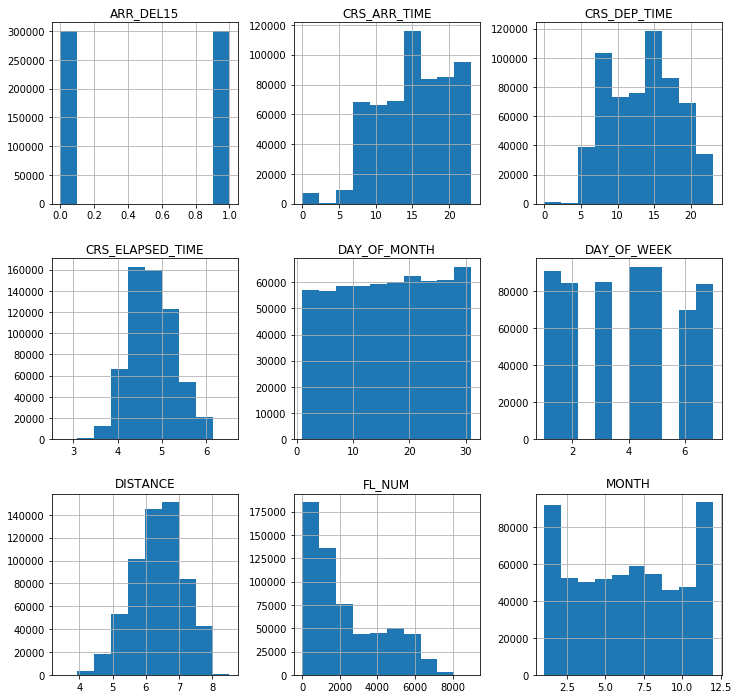

In [24]:
def log_trans(df,cols,fig_size):
    for col in log_cols:
        df[col] = df[col].astype('float64').replace(0.0, 0.01)
        df[col] = log(df[col])
    df.hist(figsize=fig_size)
    return df 

## Model 1
log_cols = ['CRS_ELAPSED_TIME','DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',\
            'LATE_AIRCRAFT_DELAY']
fl_dep1 = log_trans(fl_dep1,log_cols,(12,12))
## first convert categorical features with dummies
#fl_dep1_t = pd.get_dummies(fl_dep1)

## Model 2
log_cols = ['DEP_DELAY','TAXI_OUT','CRS_ELAPSED_TIME','DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',\
            'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
fl_arr1 = log_trans(fl_arr1,log_cols,(15,15))
## first convert categorical features with dummies
#fl_arr1_t = pd.get_dummies(fl_arr1)

## Model 3
log_cols = ['CRS_ELAPSED_TIME','DISTANCE']
fl_arr2 = log_trans(fl_arr2,log_cols,(12,12))
## first convert categorical features with dummies
#fl_arr2_t = pd.get_dummies(fl_arr2)

##### We'll start with DEP_DEL15. Convert categorical features with dummies and fill any remaining missing values with either the mean for the feature (numerical) or  with 'Missing' (categorical).

In [25]:
# Separate features (X) and DEP delay (y)
X = fl_dep1.drop('DEP_DEL15', axis=1)
y = fl_dep1['DEP_DEL15']

## find list of numerical and categorical columns
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

## Impute any remaining missing numerical values with mean 
## and categorical values  with 'Missing'
t_num = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),\
                        ('scaler', StandardScaler())])
t_obj = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant',fill_value='Missing')),\
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

xtransform = ColumnTransformer(transformers=[('num',t_num,num_cols),('cat',t_obj,cat_cols)])

##Transform features
X = xtransform.fit_transform(X)

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)


#### Model 1:  DEP_DEL15

#### We'll compare 3 algorithms:
* LogisticRegression: A simple model that uses a logistic function to model a binary dependent variable.
* RandomForestClassifier: Limits the overfitting nature of decision trees by using multiple trees and sampling feature columns and then aggregating the results.
* XGBClassifier: Also a tree based model, it uses multiple shallow trees and a gradient descent classifier to limit overfitting. 

#### First start with a simple logistic regression model for binary classification using default parameters as a baseline. Then try to improve results using l2 regularisation. Next run RandomForestClassifier with 10 trees to see if there is any improvement over logistic regression. Then  run XGBClassifier using default parameters for comparison. Lastly, we will tune some XGBClassifier parameters to see if there is any lift in model results. 

#### The evaluation metrics used are:
* Accuracy - ratio of correctly predicted observations to the total observations.
* Precision - ratio of correctly predicted positive observations (flight is delayed) to the total predicted positive observations.
* Recall - ratio of correctly predicted positive observations to the all observations in actual class.
* f1 score - weighted average of Precision and Recall, it takes both false positives and false negatives into account.

In [26]:
#LogisticRegressionCV(penalty='l2', solver='newton-cg', verbose=2)
model_s = [LogisticRegression(solver='newton-cg'), \
           RandomForestClassifier(n_estimators=10,random_state=13,verbose=2), \
           xgb.XGBClassifier(n_job=-1, verbose=2)]
model_names = ['Logistic Regression','Random Forest Classifier', 'XGBoost Classier']

accuracy_dep = []
precision_dep = []
recall_dep = []
f1_dep = []
y_preds = []
model_res = []

def run_model(m,model_name):
    print('\nFitting...')
    model_start = time.time()
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    model_end = time.time()
    print('\n'+model_name+' time to run: ', round((model_end - model_start)/60), ' minutes')
    return m,y_pred

for i,m in enumerate(model_s):
    model,y_pred = run_model(m,model_names[i])
    accuracy_dep.append( accuracy_score(y_test, y_pred) )
    precision_dep.append( precision_score(y_test, y_pred, pos_label=1) )
    recall_dep.append( recall_score(y_test, y_pred, pos_label=1))
    f1_dep.append( f1_score(y_test, y_pred, pos_label=1) )
    model_res.append(model)
    y_preds.append(y_pred)

fit_results_df = pd.DataFrame({'accuracy':accuracy_dep, 'precision':precision_dep,\
                            'recall':recall_dep, 'f1':f1_dep})
fit_results_df.set_index([model_names])



Fitting...

Logistic Regression time to run:  1  minutes

Fitting...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.4s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished



Random Forest Classifier time to run:  8  minutes

Fitting...
[00:58:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_job, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



XGBoost Classier time to run:  1  minutes


,accuracy,precision,recall,f1
Logistic Regression,0.739000,0.773398,0.677676,0.722380
Random Forest Classifier,0.876233,0.928573,0.815746,0.868511
XGBoost Classier,0.891592,0.980914,0.799198,0.880782


#### The accuracy, precision, recall and f1 score indicate that XGBClassifier, without any parameter tuning, is the superior model compared to LogisticRegression and RandomForestClassifier. LogisticRegression results do not improve with l2 regularisation. RandomForestClassifier could benefit from parameter tuning but for now we choose XGBClassifier as the best model for departure delay prediction and tune its paramters to see if there will be any improvements.  

In [27]:
##############################################################################################
####------------- THIS AREA IS COMMENTED BECAUSE IT TAKES A WHILE TO RUN -----------------####
####------------- IT WAS USED TO DETERMINE THE BEST PARAMETERS FOR XGB USING GRIDSEARCH --####
#xgb2 = xgb.XGBClassifier(n_estimators=600, objective='binary:logistic', nthread=-1)
## A parameter grid for XGBoost
#params = {'min_child_weight': [1, 5, 10],'subsample': [0.5, 0.8, 0.9],\
#          'reg_alpha': [0.5, 1.1,1.2],'learning_rate':[0.02,0.3],'max_depth': [3, 4, 5]}

# randomsearch = RandomizedSearchCV(xgb2, param_distributions=params, n_iter=10, \
#                            scoring='roc_auc', n_jobs=-1, cv=5, verbose=2, random_state=20)

#model_start = time.time()
#randomsearch.fit(X_train, y_train)
#model_end = time.time()
#print('\nXGBoost time to run: ', round((model_end - model_start)/60), ' minutes')
####--------------------------------------------------------------------------------------####
##############################################################################################

In [28]:
xgb3 = xgb.XGBClassifier(n_estimators=600,max_depth=3,objective='binary:logistic',\
        learning_rate=0.3,subsample=0.9,min_child_weight=1,colsample_bytree=.8, reg_alpha=1.1)

x_t, x_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.25, random_state=92)
evals=[(x_t,y_t),(x_v,y_v)]
xgb3.fit( x_t, y_t, eval_set=evals,eval_metric='auc',\
                        early_stopping_rounds=20,verbose=2)

[0]	validation_0-auc:0.90704	validation_1-auc:0.90694
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[2]	validation_0-auc:0.91177	validation_1-auc:0.91198
[4]	validation_0-auc:0.91406	validation_1-auc:0.91411
[6]	validation_0-auc:0.91955	validation_1-auc:0.91951
[8]	validation_0-auc:0.92012	validation_1-auc:0.92006
[10]	validation_0-auc:0.92325	validation_1-auc:0.92315
[12]	validation_0-auc:0.92371	validation_1-auc:0.92356
[14]	validation_0-auc:0.92497	validation_1-auc:0.92467
[16]	validation_0-auc:0.92576	validation_1-auc:0.92565
[18]	validation_0-auc:0.92657	validation_1-auc:0.92640
[20]	validation_0-auc:0.92757	validation_1-auc:0.92735
[22]	validation_0-auc:0.92775	validation_1-auc:0.92751
[24]	validation_0-auc:0.92812	validation_1-auc:0.92777
[26]	validation_0-auc:0.92843	validation_1-auc:0.92809
[28]	validation_0-auc:0.92918	validation_1-auc:0.92880
[30]	validation_0-auc:0

[290]	validation_0-auc:0.94155	validation_1-auc:0.93816
[292]	validation_0-auc:0.94156	validation_1-auc:0.93816
[294]	validation_0-auc:0.94159	validation_1-auc:0.93818
[296]	validation_0-auc:0.94164	validation_1-auc:0.93821
[298]	validation_0-auc:0.94169	validation_1-auc:0.93825
[300]	validation_0-auc:0.94172	validation_1-auc:0.93826
[302]	validation_0-auc:0.94176	validation_1-auc:0.93828
[304]	validation_0-auc:0.94178	validation_1-auc:0.93829
[306]	validation_0-auc:0.94181	validation_1-auc:0.93832
[308]	validation_0-auc:0.94183	validation_1-auc:0.93832
[310]	validation_0-auc:0.94185	validation_1-auc:0.93832
[312]	validation_0-auc:0.94189	validation_1-auc:0.93830
[314]	validation_0-auc:0.94191	validation_1-auc:0.93832
[316]	validation_0-auc:0.94194	validation_1-auc:0.93832
[318]	validation_0-auc:0.94196	validation_1-auc:0.93832
[320]	validation_0-auc:0.94200	validation_1-auc:0.93833
[322]	validation_0-auc:0.94203	validation_1-auc:0.93834
[324]	validation_0-auc:0.94207	validation_1-auc:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=1.1,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### XGBClassier, with some tuning (learning rate, subsample, etc.), does not improve the results as the evaluation values are comparable.  Tuning other parameters may help in this regard, however, that would be more computationally expensive.

In [29]:
y_pred = xgb3.predict(X_test, ntree_limit=xgb3.best_ntree_limit)
accuracy_dep.append( accuracy_score(y_test, y_pred) )
precision_dep.append( precision_score(y_test, y_pred, pos_label=1) )
recall_dep.append( recall_score(y_test, y_pred, pos_label=1))
f1_dep.append( f1_score(y_test, y_pred, pos_label=1) )
model_res.append(xgb3)
y_preds.append(y_pred)

model_names = model_names+['XGBoost Classier2']
fit_results_df = pd.DataFrame({'accuracy':accuracy_dep, 'precision':precision_dep,\
                            'recall':recall_dep, 'f1':f1_dep})
fit_results_df.set_index([model_names])



,accuracy,precision,recall,f1
Logistic Regression,0.739000,0.773398,0.677676,0.722380
Random Forest Classifier,0.876233,0.928573,0.815746,0.868511
XGBoost Classier,0.891592,0.980914,0.799198,0.880782
XGBoost Classier2,0.890925,0.980982,0.797785,0.879949


#### The models' confusion matrices show that although logistic regression is more balanced in its correct (positve and negative)/ incorrect predictions, XGBClassifier has a higher fraction of correct predictions, but it is also more likely to incorrectly predict that a flight will be delayed vs. incorrectly predicting that it will not be delayed.

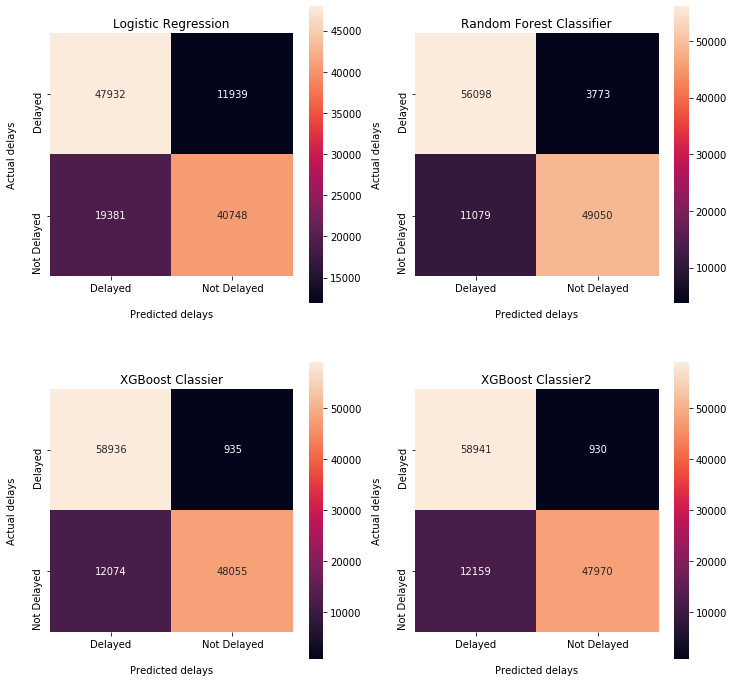

In [30]:
n=0
fig,ax1 = plt.subplots(2,2,figsize=(12,12))
for b, a in zip(y_preds, ax1.flatten()):
    confusion = confusion_matrix(y_test, b)
    labels = ['Delayed', 'Not Delayed']
    sns.heatmap(confusion,annot=True,square=True,xticklabels=labels,\
                yticklabels=labels,fmt='g',ax=a)
    a.set_xlabel('\nPredicted delays')
    a.set_ylabel('Actual delays\n')
    a.set_title(model_names[n])
    n+=1

#### Check the most important features

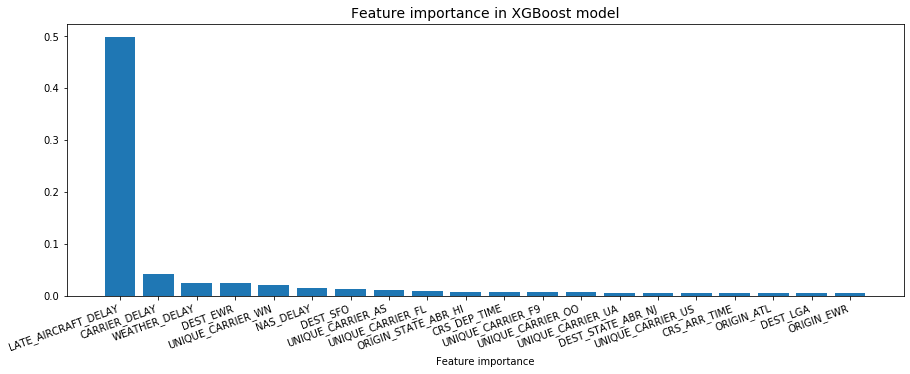

In [31]:
def get_feature_names(columnTransformer):
    output_features = []
    for name, pipe, features in columnTransformer.transformers_:
        if name!='remainder':
            for i in pipe:
                trans_features = []
                if hasattr(i,'categories_'):
                    trans_features.extend(i.get_feature_names(features))
                else:
                    trans_features = features
            output_features.extend(trans_features)
    return output_features

feature_weights_xgb = pd.DataFrame(model_res[2].feature_importances_,\
                                   index = get_feature_names(xtransform),columns=['weight'])
feature_weights_xgb.sort_values('weight', inplace=True, ascending=False)

# Plotting feature importances
fig,ax1 = plt.subplots(1,1, figsize=(15,5))
plt.bar(feature_weights_xgb.index[:20], feature_weights_xgb.weight[:20], align='center') 
plt.title("Feature importance in XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
#plt.margins(y=0.01)
for label in ax1.get_xticklabels():
    label.set_rotation(20)
    label.set_ha('right')
plt.savefig('figures/Feature_importance_xgb.png', bbox_inches='tight', format='png',  dpi=200)

#### Expectedly, the 3 most important features are cause of delay features, viz.  CARRIER_DELAY, LATE_AIRCRAFT and WEATHER_DELAY. Southwest Airlines Co., Alaska Airlines Inc. and AirTran Airways Corporation are the 5th, 8th and 9th most important,  respectively. Newark airport and San Francisco airport are the 4th and 7th most important and Hawaii (origin state) also features in the top 10.

#### Now that we have obtained the best model, we can save it for testing purposes on unseen data.

In [32]:
## save the model
dump(model_res[2], open('model_depdel_f.pkl', 'wb'))
# save the scaler
dump(xtransform, open('scaler_depdel_f.pkl', 'wb'))


#### Finaly, we can then load the model to test the validation dataset that was left out. First, perform the necessary transformations on the dataset and then test the model on it. Define functions that perform time, log and tranformation conversions and run the model.

In [33]:

## function to convert to time (in hours)
def conv_to_time(df,col):
    df[col] = df[col].astype('int64')
    df[col] = df[col].astype('str')
    df[col] = df[col].apply('{0:0>4}'.format)
    df[col].replace('2400', '0000', inplace=True)
    df[col] = pd.to_datetime(df[col], format='%H%M').dt.hour
    return df[col]

## Function to log transform
def log_trans(df,cols):
    for col in log_cols:
        df[col] = df[col].astype('float64').replace(0.0, 0.01)
        df[col] = log(df[col])
    return df 

## Function to load and run model
def run_saved_model(model_name,hold_out_file,y_col,modelpkl,scalerpkl,cols_to_drop,log_cols):
    
    print('Test validation data on ',model_name, ':\n')
    
    print('Loading dataset...')
    hold_out_df = pd.read_csv(hold_out_file)

    print('Loading model...')
    model = load(open(modelpkl, 'rb'))
    scaler = load(open(scalerpkl, 'rb'))

    ##Transform dataset to be the same structure as training dataset
    print('Transforming dataset...')
    
    hold_out_df = hold_out_df[hold_out_df['CANCELLED'] == 0]
    hold_out_df = hold_out_df[hold_out_df['DIVERTED'] == 0]
    hold_out_df.drop(['CANCELLED','CANCELLATION_CODE','DIVERTED'], axis=1, inplace=True)
    hold_out_df.dropna(axis=1, how='all', inplace=True)

    cols_to_conv = ['CRS_DEP_TIME','DEP_TIME','CRS_ARR_TIME','ARR_TIME']
    for col in cols_to_conv:
        hold_out_df[col] = conv_to_time(hold_out_df,col)
    
    cols_to_drop_f = ['ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','FLIGHTS','FL_DATE']
    hold_out_df = hold_out_df.drop(cols_to_drop_f,axis=1)

    hold_out_df = hold_out_df.drop(cols_to_drop,axis=1)
    print('Log transform...')
    hold_out_df = log_trans(hold_out_df,log_cols)
    
    # Separate features (X) and DEP delay (y)
    X = hold_out_df.drop(y_col, axis=1)
    y = hold_out_df[y_col]

    print('Scaling...')
    X_hold = scaler.transform(X)
    print('Making predictions...')
    y_hold_pred = model.predict(X_hold)
    print('\nValidation Dataset:',X_hold.shape,'\n')
    # Evaluate
    print('Accuracy: ', accuracy_score(y, y_hold_pred))
    print('Precision: ', precision_score(y, y_hold_pred, pos_label=1))
    print('Recall: ', recall_score(y, y_hold_pred, pos_label=1))
    print('f1_score ', f1_score(y, y_hold_pred, pos_label=1))
    
    plt.figure(figsize=(5,5))
    confusion = confusion_matrix(y, y_hold_pred)
    labels = ['Delayed', 'Not Delayed']
    sns.heatmap(confusion,annot=True,square=True,xticklabels=labels,\
                yticklabels=labels,fmt='g')
    plt.xlabel('\nPredicted delays')
    plt.ylabel('Actual delays\n')
    plt.title('Confusion Matrix: VALIDATION')

Test validation data on  DEP DELAY :

Loading dataset...
Loading model...
Transforming dataset...
Log transform...
Scaling...
Making predictions...

Validation Dataset: (1952, 767) 

Accuracy:  0.9554303278688525
Precision:  0.9191919191919192
Recall:  0.8125
f1_score  0.8625592417061612


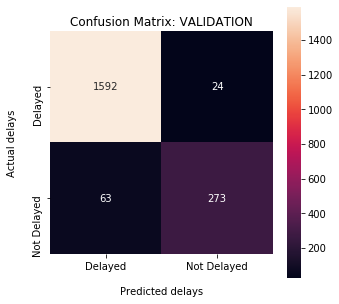

In [34]:
###############################################################
## VALIDATION Test for Model 1: DEP DELAY
cols_to_drop = ['DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DELAY_GROUP', 'TAXI_OUT', \
                'TAXI_IN', 'WHEELS_OFF', 'WHEELS_ON', 'ARR_TIME', 'ARR_DELAY', 'TAIL_NUM', \
                'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ACTUAL_ELAPSED_TIME', \
                'AIR_TIME', 'DISTANCE_GROUP', 'YEAR']

log_cols = ['CRS_ELAPSED_TIME','DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', \
            'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

run_saved_model('DEP DELAY','hold_out_test.csv','DEP_DEL15',\
                                'model_depdel_f.pkl','scaler_depdel_f.pkl',\
                                 cols_to_drop,log_cols)
###############################################################

#### Run XGBClassifier on the other 2 models (arrival delays)


Fitting...

XGBoost Classier time to run:  1  minutes
Model 2: ARR DELAY
Accuracy:  0.9999916666666666
Precision:  1.0
Recall:  0.999983339719774
f1_score  0.9999916697904953
Test validation data on  ARR DELAY 1 :

Loading dataset...
Loading model...
Transforming dataset...
Log transform...
Scaling...
Making predictions...

Validation Dataset: (1952, 768) 

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
f1_score  1.0


/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


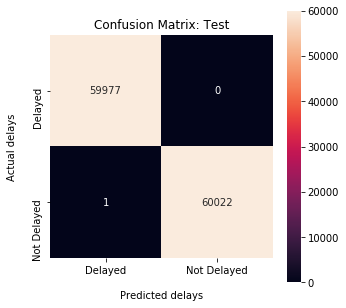

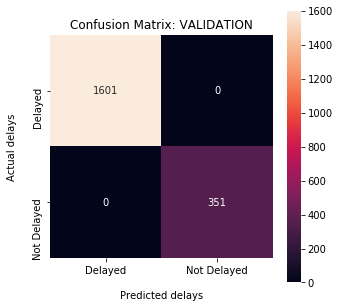

In [35]:
## MODEL 2: ARR DELAY V1
# Separate features (X) and ARR delay (y)
X = fl_arr1.drop('ARR_DEL15', axis=1)
y = fl_arr1['ARR_DEL15']

## find list of numerical and categorical columns
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

## Impute any remaining missing numerical values with mean 
## and categorical values  with 'Missing'
t_num = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),\
                        ('scaler', StandardScaler())])
t_obj = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant',fill_value='Missing')),\
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

xtransform = ColumnTransformer(transformers=[('num',t_num,num_cols),('cat',t_obj,cat_cols)])

##Transform features
X = xtransform.fit_transform(X)

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

##Run model
model,y_pred = run_model(xgb.XGBClassifier(),model_names[2])

# Train/test set: Evaluate
print('Model 2: ARR DELAY')
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, pos_label=1))
print('Recall: ', recall_score(y_test, y_pred, pos_label=1))
print('f1_score ', f1_score(y_test, y_pred, pos_label=1))
    
plt.figure(figsize=(5,5))
confusion = confusion_matrix(y_test, y_pred)
labels = ['Delayed', 'Not Delayed']
sns.heatmap(confusion,annot=True,square=True,xticklabels=labels,\
                yticklabels=labels,fmt='g')
plt.xlabel('\nPredicted delays')
plt.ylabel('Actual delays\n')
plt.title('Confusion Matrix: Test')

## Save the model
dump(model, open('model_arrdel_f1.pkl', 'wb'))
# save the scaler
dump(xtransform, open('scaler_arrdel_f1.pkl', 'wb'))

###############################################################
## VALIDATION Test for Model 2: ARR DELAY 1
cols_to_drop = ['DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'TAXI_IN', 'WHEELS_ON', \
                'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW','ARR_DELAY_GROUP','TAIL_NUM',\
                'ACTUAL_ELAPSED_TIME','AIR_TIME','DISTANCE_GROUP','YEAR']

log_cols = ['DEP_DELAY','TAXI_OUT','CRS_ELAPSED_TIME','DISTANCE', 'CARRIER_DELAY', \
            'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

run_saved_model('ARR DELAY 1','hold_out_test.csv','ARR_DEL15','model_arrdel_f1.pkl',\
                'scaler_arrdel_f1.pkl',cols_to_drop,log_cols)

###############################################################


Fitting...

XGBoost Classier time to run:  1  minutes
Model 3: ARR DELAY 2
Accuracy:  0.6333916666666667
Precision:  0.6286186533153604
Recall:  0.6526331572897056
f1_score  0.6404008533664654
Test validation data on  ARR DELAY 2 :

Loading dataset...
Loading model...
Transforming dataset...
Log transform...
Scaling...
Making predictions...

Validation Dataset: (1952, 759) 

Accuracy:  0.6306352459016393
Precision:  0.28028503562945367
Recall:  0.6723646723646723
f1_score  0.39564124056999156


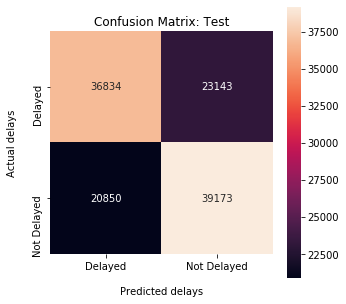

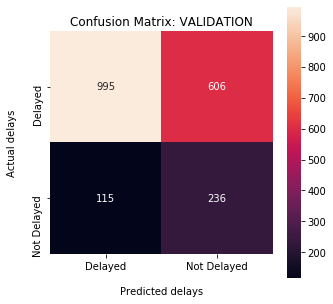

In [36]:
## MODEL 2: ARR DELAY V1
# Separate features (X) and ARR delay (y)
X = fl_arr2.drop('ARR_DEL15', axis=1)
y = fl_arr2['ARR_DEL15']

## find list of numerical and categorical columns
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

## Impute any remaining missing numerical values with mean 
## and categorical values  with 'Missing'
t_num = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),\
                        ('scaler', StandardScaler())])
t_obj = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant',fill_value='Missing')),\
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

xtransform = ColumnTransformer(transformers=[('num',t_num,num_cols),('cat',t_obj,cat_cols)])

##Transform features
X = xtransform.fit_transform(X)

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

##Run model
model,y_pred = run_model(xgb.XGBClassifier(),model_names[2])

# Train/test set: Evaluate
print('Model 3: ARR DELAY 2')
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, pos_label=1))
print('Recall: ', recall_score(y_test, y_pred, pos_label=1))
print('f1_score ', f1_score(y_test, y_pred, pos_label=1))
    
plt.figure(figsize=(5,5))
confusion = confusion_matrix(y_test, y_pred)
labels = ['Delayed', 'Not Delayed']
sns.heatmap(confusion,annot=True,square=True,xticklabels=labels,\
                yticklabels=labels,fmt='g')
plt.xlabel('\nPredicted delays')
plt.ylabel('Actual delays\n')
plt.title('Confusion Matrix: Test')

## Save the model
dump(model, open('model_arrdel_f2.pkl', 'wb'))
# save the scaler
dump(xtransform, open('scaler_arrdel_f2.pkl', 'wb'))

###############################################################
## VALIDATION Test for Model 3: ARR DELAY 2

cols_to_drop = ['DEP_TIME','DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', \
                'TAXI_OUT', 'TAXI_IN','WHEELS_OFF', 'WHEELS_ON', 'ARR_TIME', 'ARR_DELAY', \
                'TAIL_NUM', 'ARR_DELAY_NEW', 'ARR_DELAY_GROUP','ACTUAL_ELAPSED_TIME', \
                'AIR_TIME', 'DISTANCE_GROUP', 'YEAR','CARRIER_DELAY', 'WEATHER_DELAY', \
                'NAS_DELAY', 'SECURITY_DELAY','LATE_AIRCRAFT_DELAY']

log_cols = ['CRS_ELAPSED_TIME','DISTANCE']

run_saved_model('ARR DELAY 2','hold_out_test.csv','ARR_DEL15','model_arrdel_f2.pkl',\
                'scaler_arrdel_f2.pkl',cols_to_drop,log_cols)
################################################################

#### Finally, as seen above, when predicting arrival delays, if one has departure information (DEP_DELAY, DEP_TIME, as well as cause of delay columns), then the model is highly likely to predict whether a delay will occur or not. This is, however, often unrealistic. Removing these features reduces the accuracy and recall by ~40%, and the model performs worse than the DEP_DEL15 model. The precision and f1 score of the validation dataset are only 0.28 and 0.39, respectively, which indicates overfitting. This model could be improved with hyperameter tuning.

#### Future improvements/Thoughts:
* Hyperameter tuning for ARR_DEL15 prediction dataset.
* Running larger samples with parallel computing on more cores.
* Use RNN neural network because it learns from earlier time steps.